# Reading data cleaned

In [1]:
# Importing required libraries
import pandas as pd 
import os

# Define dtype_dict: Data Types for DataFrame Columns
dtype_dict = {
    'Région': str,  # Categorical data
    'Départements': str,  # Categorical data
    'Code commune (INSEE)': str,  # Identifier; non-numeric
    'Commune': str,  # Categorical data
    'nombre de redevables': int,  # Count; integer
    'patrimoine moyen en €': int,  # Monetary; integer
    'impôt moyen en €': int,  # Monetary; integer
    "patrimoine moyen en millions d'euros": float,  # Monetary in millions; float
    "impôt moyen en milliers d'euros": float,  # Monetary in thousands; float
}

# List all files in the folder
path=r'G:\Mi unidad\Godi.AI\Operations\Freelancer\Projets\Impots sur la fortune\TensorFlow_Prediction_5YearFrench_IFI\TensorFlow_Prediction_5YearFrench_IFI\DataIn'
all_files = os.listdir(path)

# Filter files that start with 'ificom'
ificom_files = [f for f in all_files if f.startswith('ificom')]

# Initialize an empty DataFrame to hold all the data
df_ificom = pd.DataFrame()

# Read each file and append it to all_data
for file in ificom_files:
    df_temp = pd.read_excel(os.path.join(path, file), header=0, skiprows=1, dtype=dtype_dict)
    
    # Add a new column with the filename
    df_temp['filename'] = file
    
    df_ificom = pd.concat([df_ificom, df_temp], ignore_index=True)
    
# Due to inconsistencies in column naming, especially in the 2019 ificom dataset, 
# we need to harmonize the column names by moving data from alternate columns to 
# the primary columns, if the primary columns have NaN values.

# Harmonize 'Départements'
df_ificom.loc[df_ificom['Départements'].isna(), 'Départements'] = df_ificom['Département']

# Harmonize 'Code commune (INSEE)'
df_ificom.loc[df_ificom['Code commune (INSEE)'].isna(), 'Code commune (INSEE)'] = df_ificom['Code de la commune (INSEE)']

# Harmonize 'Commune'
df_ificom.loc[df_ificom['Commune'].isna(), 'Commune'] = df_ificom['Nom de la commune']

# Harmonize 'nombre de redevables'
df_ificom.loc[df_ificom['nombre de redevables'].isna(), 'nombre de redevables'] = df_ificom['Nombre de redevables']

# Harmonize 'patrimoine moyen en €'
df_ificom.loc[df_ificom['patrimoine moyen en €'].isna(), 'patrimoine moyen en €'] = df_ificom['Patrimoine moyen en €']

# Harmonize 'impôt moyen en €'
df_ificom.loc[df_ificom['impôt moyen en €'].isna(), 'impôt moyen en €'] = df_ificom['Impôt moyen en €']

# Drop redundant columns
redundant_columns = ['Département', 'Code de la commune (INSEE)', 'Nom de la commune', 
                     'Nombre de redevables', 'Patrimoine moyen en €', 'Impôt moyen en €']
df_ificom.drop(columns=redundant_columns, axis=1, inplace=True)

# UNIT CONVERSION AND COLUMN CLEANUP
# Updates 'patrimoine moyen en €' and 'impôt moyen en €' based on available alternate units,
# and removes redundant columns.

# Update 'patrimoine moyen en €' based on available values in 'patrimoine moyen en millions d'euros'
mask_for_patrimoine = pd.notna(df_ificom['patrimoine moyen en millions d\'euros'])
df_ificom.loc[mask_for_patrimoine, 'patrimoine moyen en €'] = df_ificom.loc[mask_for_patrimoine, 'patrimoine moyen en millions d\'euros'] * 1_000_000

# Update 'impôt moyen en €' based on available values in 'impôt moyen en milliers d'euros'
mask_for_impot = pd.notna(df_ificom['impôt moyen en milliers d\'euros'])
df_ificom.loc[mask_for_impot, 'impôt moyen en €'] = df_ificom.loc[mask_for_impot, 'impôt moyen en milliers d\'euros'] * 1_000

# Drop the redundant columns
df_ificom.drop(['patrimoine moyen en millions d\'euros', 'impôt moyen en milliers d\'euros'], axis=1, inplace=True)

# YEAR EXTRACTION FROM FILENAME
# Extract the year information from the 'filename' column and convert it to a numeric type.
# Extract the year from the filename and add it as a new column
df_ificom['year'] = df_ificom['filename'].apply(lambda x: x.split('-')[-1].split('.')[0] if '-' in x else x[-8:-5])
df_ificom['year'] = pd.to_numeric(df_ificom['year'], errors='coerce')

# Column Renaming for Enhanced Readability and Standardization
df_ificom.rename(columns={'Région': 'Region', 'Départements': 'Department', 'Code commune (INSEE)': 'Commune_Code_INSEE', 'Commune': 'City',
                          'nombre de redevables': 'Number_of_Taxpayers', 'patrimoine moyen en €': 'Average_Assets_in_Euro',
                          'impôt moyen en €': 'Average_Tax_in_Euro', 'filename': 'Source_File', 'year': 'Year'}, inplace=True)
# Remove spaces and convert 'Commune_Code_INSEE' to string
df_ificom['Commune_Code_INSEE'] = df_ificom['Commune_Code_INSEE'].astype(str).str.replace(' ', '', regex=False)

# Load unique INSEE codes and final city names
unique_grouped_sorted = pd.read_excel(r'G:\Mi unidad\Godi.AI\Operations\Freelancer\Projets\Impots sur la fortune\TensorFlow_Prediction_5YearFrench_IFI\TensorFlow_Prediction_5YearFrench_IFI\DataIn\unique_grouped_sorted.xlsx', dtype=str).loc[:, ['Commune_Code_INSEE', 'Final_City']].drop_duplicates()

# Merge and update 'City' in original DataFrame
merged_df = df_ificom.merge(unique_grouped_sorted, on='Commune_Code_INSEE', how='left')
merged_df.loc[~merged_df['Final_City'].isna(), 'City'] = merged_df['Final_City']
df_ificom = merged_df.drop(columns=['Final_City'])

# Adding to GPS coordinates to the dataframe

In [2]:
    
df_coordinates_gps=pd.read_csv(r'G:\Mi unidad\Godi.AI\Operations\Freelancer\Projets\Impots sur la fortune\TensorFlow_Prediction_5YearFrench_IFI\TensorFlow_Prediction_5YearFrench_IFI\DataIn\communes-departement-region.csv',
            dtype={'code_commune_INSEE': str, 'latitude': float, 'longitude': float})[['code_commune_INSEE','latitude','longitude']]

#Fill with 0 at the beginig 
df_coordinates_gps['code_commune_INSEE'] = df_coordinates_gps['code_commune_INSEE'].str.zfill(5)
df_coordinates_gps.rename(columns={'code_commune_INSEE':'Commune_Code_INSEE'},inplace=True)

#merge the df_ificom with the coordinates
df_ificom=df_ificom.merge(df_coordinates_gps, how='left', on='Commune_Code_INSEE')

#Building new messure with total tax payed per city
df_ificom['total_tax_per_city']=df_ificom['Average_Tax_in_Euro']*df_ificom['Number_of_Taxpayers']

#Cache data
df_ificom.to_csv(r'G:\Mi unidad\Godi.AI\Operations\Freelancer\Projets\Impots sur la fortune\TensorFlow_Prediction_5YearFrench_IFI\TensorFlow_Prediction_5YearFrench_IFI\Dataout\df_ificom.csv',index=False)

# Predicting Model

In [3]:
# Libraries reading 
# 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


#Selecting the good data to use in the prediction
df_ificom_clean = df_ificom.dropna(subset=['latitude', 'longitude', 'Year', 'total_tax_per_city'])

#Some duplicates values present in the data  leeping the first one becasue all are the same
df_ificom_clean = df_ificom_clean.drop_duplicates( keep='first').reset_index(drop=True)


In [4]:
df_ificom_clean.shape

(781, 12)

        #### Feature enginering for ML model

In [5]:
#FEATURE 1: LAGGED DATA
# Adding the lagged data, for machine learning model: Estas características permitirán a tu modelo aprender tendencias y patrones a lo largo del tiempo para cada ciudad.

df_ificom_clean=df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year'])

# Calculando las variables lagged
df_ificom_clean.loc[:,'total_tax_per_city_lag1'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)
df_ificom_clean.loc[:,'total_tax_per_city_lag2'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(2)
df_ificom_clean.loc[:,'total_tax_per_city_lag3'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(3)

In [6]:
#FEATURE 2: ROLLING MEAN

df_ificom_clean.loc[:,'total_tax_per_city_roll2'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].rolling(2).mean().reset_index(0,drop=True)

In [7]:
#FEATURE 3: TENDENCIA por CIUDAD
import numpy as np 

def calculate_trend(group):
    # Regresión lineal
    A = np.vstack([group['Year'], np.ones(len(group))]).T
    m, c = np.linalg.lstsq(A, group['total_tax_per_city'], rcond=None)[0]
    return m

trends = df_ificom_clean.sort_values(by=['Commune_Code_INSEE','Year']).groupby('Commune_Code_INSEE').apply(calculate_trend)

df_ificom_clean=df_ificom_clean.merge(trends.reset_index().rename(columns={0:'trend'}), on='Commune_Code_INSEE', how='left')

In [8]:
#FEATURE 4: GENERAL STATS (sin tener en cuenta el valor actual de cada linea, ya que para la preEsto es para evitar el "leakage" de datos, es decir, darle información al modelo sobre la variable objetivo que no se supone que debe conocer.)

def compute_stats(row):
    # Filtrar el dataframe para obtener solo las filas anteriores al año actual y para la misma ciudad
    previous_data = df_ificom_clean[
        (df_ificom_clean['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) & 
        (df_ificom_clean['Year'] < row['Year'])
    ]['total_tax_per_city']

    # Si no hay datos anteriores, retornar NaN para todas las estadísticas
    if previous_data.empty:
        return pd.Series({
            'mean': None,
            'median': None,
            'minimum': None,
            'maximum': None,
            'std_dev': None
        })

    # Calcular las estadísticas
    stats = {
        'mean': previous_data.mean(),
        'median': previous_data.median(),
        'minimum': previous_data.min(),
        'maximum': previous_data.max(),
        'std_dev': previous_data.std()
    }

    return pd.Series(stats)

# Aplicar la función para calcular las estadísticas
stats_df = df_ificom_clean.apply(compute_stats, axis=1)

# Agregar las estadísticas al dataframe original
df_ificom_clean = pd.concat([df_ificom_clean, stats_df], axis=1)


In [9]:
#FEATURE 5: MEAN DISTANCE TO THE CLOSEST CITY 10 
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the earth in kilometers.
    """
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    return distance

# Create a temporary DataFrame with unique cities (based on Commune_Code_INSEE)
unique_cities = df_ificom_clean.drop_duplicates(subset='Commune_Code_INSEE')[['latitude', 'longitude', 'Commune_Code_INSEE']]

# Create a DataFrame to store distances for unique cities
unique_distances = pd.DataFrame(index=unique_cities['Commune_Code_INSEE'], columns=unique_cities['Commune_Code_INSEE'])

# Calculate distances between each pair of unique cities
for i, row1 in unique_cities.iterrows():
    for j, row2 in unique_cities.iterrows():
        unique_distances.at[row1['Commune_Code_INSEE'], row2['Commune_Code_INSEE']] = haversine_distance(
            row1['latitude'], row1['longitude'], row2['latitude'], row2['longitude']
        )

# Calculate mean distance to the 10 nearest cities for each unique city
mean_distances_to_10_nearest_unique = {}

for city in unique_cities['Commune_Code_INSEE']:
    sorted_distances = unique_distances.loc[city].sort_values()
    # Exclude the city itself (distance = 0) and take the next 10 closest cities
    mean_distance = sorted_distances.iloc[1:11].mean()
    mean_distances_to_10_nearest_unique[city] = mean_distance

# Add the calculated mean distances to the original DataFrame
df_ificom_clean['mean_distance_to_10_nearest'] = df_ificom_clean['Commune_Code_INSEE'].map(mean_distances_to_10_nearest_unique)


    #Starting with ML ABT data

In [11]:
df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City',
       'Number_of_Taxpayers', 'Average_Assets_in_Euro', 'Average_Tax_in_Euro',
       'Source_File', 'Year', 'latitude', 'longitude', 'total_tax_per_city',
       'total_tax_per_city_lag1', 'total_tax_per_city_lag2',
       'total_tax_per_city_lag3', 'total_tax_per_city_roll2', 'trend', 'mean', 'median', 'minimum',
       'maximum', 'std_dev', 'mean_distance_to_10_nearest']].reset_index(drop=True, inplace=True)

ID_df=df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City']]
ABT=[['total_tax_per_city','Year','latitude', 'longitude','total_tax_per_city_lag1', 'total_tax_per_city_lag2','total_tax_per_city_lag3', 
      'total_tax_per_city_roll3','total_tax_per_city_roll2', 'trend', 'mean', 'median', 'minimum','maximum', 'std_dev', 
      'mean_distance_to_10_nearest']]

#Building the model

In [13]:
# Separar características y objetivo
X = df_ificom_clean[['Year','latitude', 'longitude','total_tax_per_city_lag1', 'total_tax_per_city_lag2','total_tax_per_city_lag3', 
      'total_tax_per_city_roll2', 'trend', 'mean', 'median', 'minimum','maximum', 'std_dev', 
      'mean_distance_to_10_nearest']].fillna(0)
y = df_ificom_clean['total_tax_per_city']

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

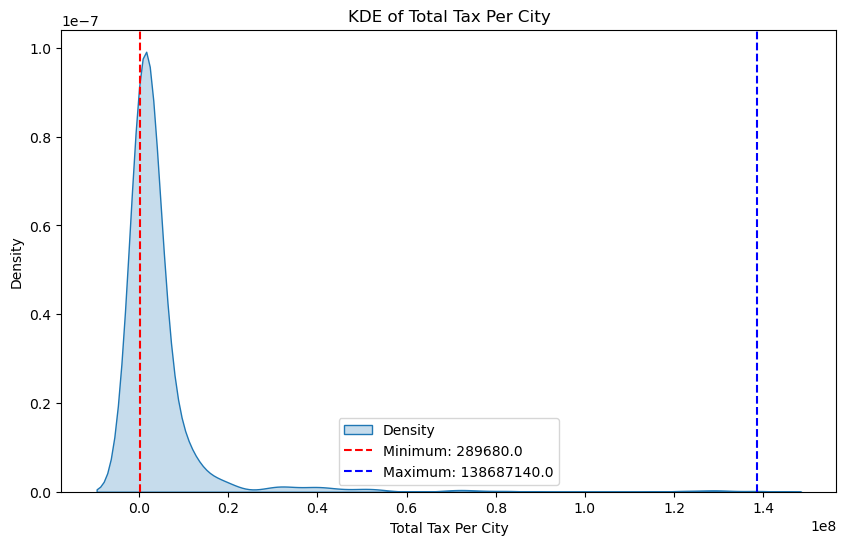

In [23]:
#Graph KDE of Y

import matplotlib.pyplot as plt
import seaborn as sns


# Crear el gráfico KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(y, fill=True, label='Density')
plt.axvline(min(y), color='red', linestyle='--', label=f'Minimum: {min(y)}')
plt.axvline(max(y), color='blue', linestyle='--', label=f'Maximum: {max(y)}')
plt.xlabel('Total Tax Per City')
plt.ylabel('Density')
plt.title('KDE of Total Tax Per City')
plt.legend()
plt.show()

In [14]:
#Linear regression:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Crear y entrenar el modelo de regresión lineal
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predecir en el conjunto de prueba y en el conjunto de entrenamiento
y_pred = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

# Evaluar el modelo en el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Evaluar el modelo en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Crear un DataFrame para almacenar los resultados
results_df = pd.DataFrame({
    'Model': ['Linear Regression'],
    'MSE_test': [mse],
    'R2_test': [r2],
    'MAE_test': [mae],
    'MSE_train': [mse_train],
    'R2_train': [r2_train],
    'MAE_train': [mae_train]
})

In [15]:
results_df

,Model,MSE_test,R2_test,MAE_test,MSE_train,R2_train,MAE_train
0,Linear Regression,4.144690e+12,0.917513,1.016303e+06,1.170796e+13,0.935017,1.349652e+06


In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Crear y entrenar el modelo de árbol de decisiones con parámetros ajustados para prevenir overfitting
regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5)
regressor.fit(X_train, y_train)

# Predecir en el conjunto de prueba y en el conjunto de entrenamiento
y_pred = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

# Evaluar el modelo en el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Evaluar el modelo en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Añadir los resultados al DataFrame existente
new_results = pd.DataFrame({
    'Model': ['Decision Tree (Adjusted)'],
    'MSE_test': [mse],
    'R2_test': [r2],
    'MAE_test': [mae],
    'MSE_train': [mse_train],
    'R2_train': [r2_train],
    'MAE_train': [mae_train]
})

results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df


,Model,MSE_test,R2_test,MAE_test,MSE_train,R2_train,MAE_train
0,Decision Tree,3.383126e+12,0.932669,492248.770701,0.000000e+00,1.000000,0.000000e+00
1,Decision Tree (Adjusted),3.948906e+12,0.921409,823595.044432,1.586266e+13,0.911957,1.257720e+06


In [19]:
#Decision tree automatically adjusted
from sklearn.model_selection import GridSearchCV

# Definir el espacio de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Crear el modelo base
tree_regressor = DecisionTreeRegressor()

# Crear el GridSearchCV
grid_search = GridSearchCV(tree_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Entrenar el GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_tree = grid_search.best_estimator_

# Predecir con el mejor modelo
y_pred = best_tree.predict(X_test)
y_pred_train = best_tree.predict(X_train)

# Evaluar el modelo en el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Evaluar el modelo en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Añadir los resultados al DataFrame existente
new_results = pd.DataFrame({
    'Model': ['Decision Tree (Grid Search)'],
    'MSE_test': [mse],
    'R2_test': [r2],
    'MAE_test': [mae],
    'MSE_train': [mse_train],
    'R2_train': [r2_train],
    'MAE_train': [mae_train]
})

results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df


,Model,MSE_test,R2_test,MAE_test,MSE_train,R2_train,MAE_train
0,Decision Tree,3.383126e+12,0.932669,492248.770701,0.000000e+00,1.000000,0.000000e+00
1,Decision Tree (Adjusted),3.948906e+12,0.921409,823595.044432,1.586266e+13,0.911957,1.257720e+06
2,Decision Tree (Grid Search),3.132309e+12,0.937661,476974.937387,5.570797e+10,0.999691,1.270209e+05


In [25]:
#Random Forest:
from sklearn.ensemble import RandomForestRegressor

# Definir el espacio de hiperparámetros
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Crear el modelo base para Random Forest
rf_regressor = RandomForestRegressor()

# Crear el GridSearchCV para Random Forest
grid_search_rf = GridSearchCV(rf_regressor, param_grid_rf, cv=5, scoring='neg_mean_squared_error')

# Entrenar el GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Obtener el mejor modelo
best_rf = grid_search_rf.best_estimator_

# Predecir con el mejor modelo
y_pred_rf = best_rf.predict(X_test)
y_pred_train_rf = best_rf.predict(X_train)

# Evaluar el modelo en el conjunto de prueba
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Evaluar el modelo en el conjunto de entrenamiento
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)

# Añadir los resultados al DataFrame existente
new_results_rf = pd.DataFrame({
    'Model': ['Random Forest (Grid Search)'],
    'MSE_test': [mse_rf],
    'R2_test': [r2_rf],
    'MAE_test': [mae_rf],
    'MSE_train': [mse_train_rf],
    'R2_train': [r2_train_rf],
    'MAE_train': [mae_train_rf]
})

results_df = pd.concat([results_df, new_results_rf], ignore_index=True)
results_df


,Model,MSE_test,R2_test,MAE_test,MSE_train,R2_train,MAE_train
0,Decision Tree,3.383126e+12,0.932669,492248.770701,0.000000e+00,1.000000,0.000000e+00
1,Decision Tree (Adjusted),3.948906e+12,0.921409,823595.044432,1.586266e+13,0.911957,1.257720e+06
2,Decision Tree (Grid Search),3.132309e+12,0.937661,476974.937387,5.570797e+10,0.999691,1.270209e+05
3,Random Forest (Grid Search),2.906683e+12,0.942151,476448.585851,2.054281e+12,0.988598,4.244324e+05


In [37]:
#XGBoost
import xgboost as xgb

# Definir el espacio de hiperparámetros para XGBoost
param_grid_xgb = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.25, 0.5, 1.0],
}

# Crear el modelo base para XGBoost
xgb_regressor = xgb.XGBRegressor()

# Crear el GridSearchCV para XGBoost
grid_search_xgb = GridSearchCV(xgb_regressor, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')

# Entrenar el GridSearchCV
grid_search_xgb.fit(X_train, y_train)

# Obtener el mejor modelo
best_xgb = grid_search_xgb.best_estimator_

# Predecir con el mejor modelo
y_pred_xgb = best_xgb.predict(X_test)
y_pred_train_xgb = best_xgb.predict(X_train)

# Evaluar el modelo en el conjunto de prueba
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Evaluar el modelo en el conjunto de entrenamiento
mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)

# Añadir los resultados al DataFrame existente
new_results_xgb = pd.DataFrame({
    'Model': ['XGBoost (Grid Search)'],
    'MSE_test': [mse_xgb],
    'R2_test': [r2_xgb],
    'MAE_test': [mae_xgb],
    'MSE_train': [mse_train_xgb],
    'R2_train': [r2_train_xgb],
    'MAE_train': [mae_train_xgb]
})

results_df = pd.concat([results_df, new_results_xgb], ignore_index=True)
results_df


In [ ]:
#Redes Neuronales 

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Definir una función para crear el modelo, requerido para KerasRegressor
def create_model(optimizer='adam', neurons=10, activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Crear el modelo
model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=10, verbose=0)

# Definir el espacio de hiperparámetros
param_grid_nn = {
    'optimizer': ['SGD', 'Adam'],
    'epochs': [10, 50, 100],
    'batch_size': [10, 20, 50],
    'neurons': [10, 20, 30],
    'activation': ['relu', 'tanh']
}

# Crear el GridSearchCV
grid_search_nn = GridSearchCV(estimator=model, param_grid=param_grid_nn, scoring='neg_mean_squared_error', cv=3)

# Entrenar el GridSearchCV
grid_search_nn.fit(X_train, y_train)

# Obtener el mejor modelo
best_nn = grid_search_nn.best_estimator_

# Predecir con el mejor modelo
y_pred_nn = best_nn.predict(X_test)
y_pred_train_nn = best_nn.predict(X_train)

# Evaluar el modelo en el conjunto de prueba
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)

# Evaluar el modelo en el conjunto de entrenamiento
mse_train_nn = mean_squared_error(y_train, y_pred_train_nn)
r2_train_nn = r2_score(y_train, y_pred_train_nn)
mae_train_nn = mean_absolute_error(y_train, y_pred_train_nn)

# Añadir los resultados al DataFrame existente
new_results_nn = pd.DataFrame({
    'Model': ['Neural Network (Grid Search)'],
    'MSE_test': [mse_nn],
    'R2_test': [r2_nn],
    'MAE_test': [mae_nn],
    'MSE_train': [mse_train_nn],
    'R2_train': [r2_train_nn],
    'MAE_train': [mae_train_nn]
})

results_df = pd.concat([results_df, new_results_nn], ignore_index=True)
results_df


In [50]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [51]:
# Predecir en el conjunto de prueba
y_pred = rf_model.predict(X_test)

In [52]:
# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(732207322662.9633, 0.9944670072402058)

iperparameters

In [53]:
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a optimizar
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_


Fitting 3 folds for each of 144 candidates, totalling 432 fits


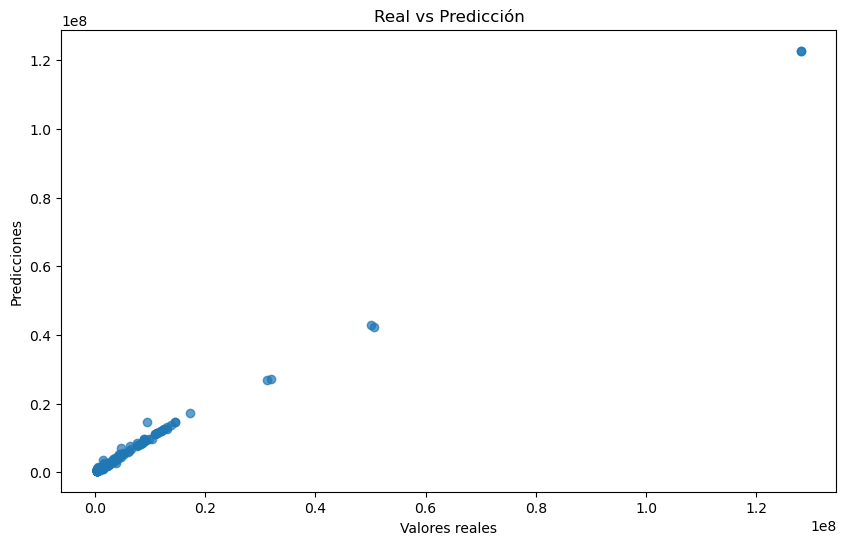

In [55]:
import matplotlib.pyplot as plt

# Predecir con el mejor modelo
y_pred_optimized = best_rf_model.predict(X_test)

# Visualizar los resultados
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_optimized, alpha=0.7)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Real vs Predicción')
plt.show()


In [56]:
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)
print(f"MSE Optimizado: {mse_optimized}")
print(f"R^2 Optimizado: {r2_optimized}")


MSE Optimizado: 912951207456.0309
R^2 Optimizado: 0.9931011992579801


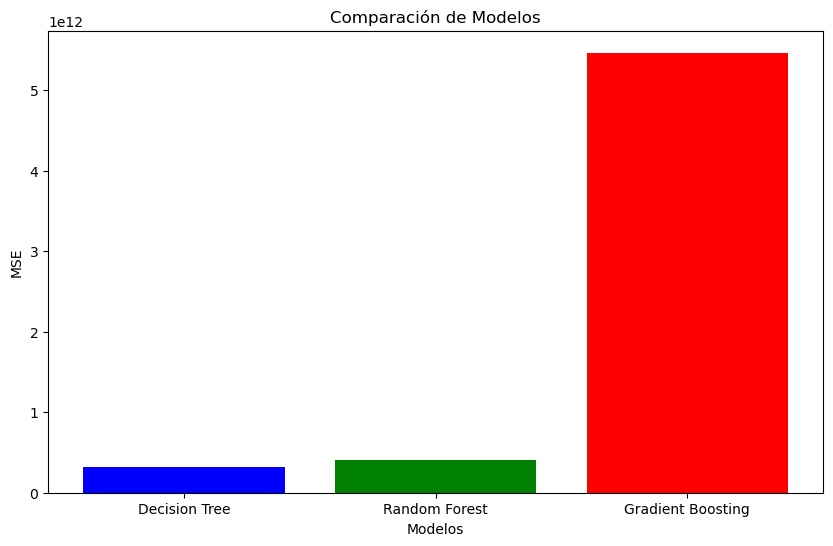

In [57]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Lista de modelos para evaluar
models = [
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor(n_estimators=100)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100))
]

# Entrena y evalúa cada modelo
model_names = []
mse_scores = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    model_names.append(name)
    mse_scores.append(mse)

# Visualiza los resultados
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_scores, color=['blue', 'green', 'red'])
plt.xlabel('Modelos')
plt.ylabel('MSE')
plt.title('Comparación de Modelos')
plt.show()


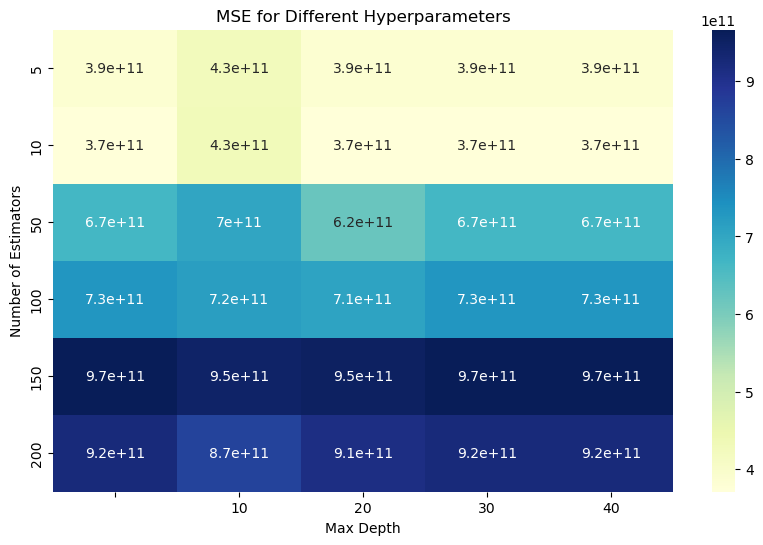

In [60]:
import numpy as np
import seaborn as sns

# Define rangos para los hiperparámetros
n_estimators_range = [5,10, 50, 100, 150, 200]
max_depth_range = [None, 10, 20, 30, 40]

# Matriz para almacenar los resultados
mse_results = np.zeros((len(n_estimators_range), len(max_depth_range)))

# Entrena el modelo para cada combinación y almacena el MSE
for i, n_estimators in enumerate(n_estimators_range):
    for j, max_depth in enumerate(max_depth_range):
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        mse_results[i, j] = mean_squared_error(y_test, y_pred)

# Visualiza los resultados en un gráfico de calor
plt.figure(figsize=(10, 6))
sns.heatmap(mse_results, annot=True, cmap='YlGnBu', 
            xticklabels=max_depth_range, yticklabels=n_estimators_range)
plt.xlabel('Max Depth')
plt.ylabel('Number of Estimators')
plt.title('MSE for Different Hyperparameters')
plt.show()


In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 2. Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X = df_ificom[['latitude', 'longitude', 'Year']]
y = df_ificom['total_tax_per_city']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
# 3. Construir el modelo con TensorFlow
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [39]:
# 4. Entrenar el modelo
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/100
39/39 [==============================] - 3s 25ms/step - loss: 161214499913728.0000 - val_loss: 84532959117312.0000
Epoch 2/100
39/39 [==============================] - 0s 11ms/step - loss: 161214516690944.0000 - val_loss: 84532950728704.0000
Epoch 3/100
39/39 [==============================] - 1s 16ms/step - loss: 161214483136512.0000 - val_loss: 84532950728704.0000
Epoch 4/100
39/39 [==============================] - 1s 16ms/step - loss: 161214516690944.0000 - val_loss: 84532950728704.0000
Epoch 5/100
39/39 [==============================] - 1s 22ms/step - loss: 161214516690944.0000 - val_loss: 84532950728704.0000
Epoch 6/100
39/39 [==============================] - 1s 15ms/step - loss: 161214499913728.0000 - val_loss: 84532950728704.0000
Epoch 7/100
39/39 [==============================] - 0s 10ms/step - loss: 161214516690944.0000 - val_loss: 84532950728704.0000
Epoch 8/100
39/39 [==============================] - 0s 11ms/step - loss: 161214516690944.0000 - val_loss: 8453

In [42]:
# 5. Predecir los valores para los próximos 5 años para cada ciudad
years_to_predict = np.array([df_ificom['Year'].max() + i for i in range(1, 6)])
predictions = {}

for city in df_ificom['Commune_Code_INSEE'].unique():
    city_data = df_ificom[df_ificom['Commune_Code_INSEE'] == city].iloc[0]
    for year in years_to_predict:
        input_data = np.array([city_data['latitude'], city_data['longitude'], year]).reshape(1, -1)
        input_data_scaled = scaler.transform(input_data)
        prediction = model.predict(input_data_scaled)
        predictions[(city, year)] = prediction[0][0]

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 230ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 159ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 337ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 148ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 76ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 174ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 123ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 92ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 181ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 210ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 106ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 111ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 85ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 87ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 123ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 87ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 67ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 176ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 81ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 85ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 97ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 104ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 90ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 126ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 65ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 183ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 91ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 124ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 122ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 44ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 45ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 79ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 209ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 107ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 118ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 74ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 174ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 133ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 103ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 86ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 116ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 76ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 114ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 192ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 96ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 90ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 248ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 92ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 105ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 98ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 104ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 174ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 117ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 118ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 97ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 101ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 67ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 179ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 240ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 142ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 71ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 177ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 298ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 401ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 198ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 240ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 193ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 161ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 247ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 542ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 182ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 742ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 145ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 153ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 196ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 106ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 303ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 207ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 84ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 179ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 383ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 462ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 219ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 244ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 176ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 86ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 267ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 748ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 256ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 144ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 115ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 156ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 654ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 131ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 101ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 95ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 206ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 86ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 92ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 106ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 102ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 118ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 145ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 140ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 94ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 164ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 116ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 109ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 85ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 130ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 188ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 89ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 81ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 212ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 98ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 97ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 81ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 95ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 87ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 75ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 97ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 114ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 74ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 98ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 137ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 79ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 487ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 418ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 105ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 198ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 80ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 100ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 86ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 108ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 45ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 84ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 87ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 85ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 65ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 301ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 142ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 71ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 75ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 98ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 131ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 76ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 67ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 109ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 172ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 74ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 96ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 127ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 232ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 65ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 198ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 566ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 159ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 74ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 91ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 75ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 231ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 75ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 102ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 89ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 216ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 99ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 216ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 124ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 119ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 143ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 91ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 215ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 98ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 106ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 94ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 127ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 105ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 105ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 108ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 75ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 100ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 181ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 107ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 172ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 118ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 94ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 169ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 65ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 214ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 79ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 105ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 67ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 65ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 173ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 44ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 115ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 102ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 79ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 138ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 264ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 178ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


In [26]:
# 2. Importación de bibliotecas
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [27]:
# Preprocesamiento
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df_ificom[['latitude', 'longitude', 'Year']])
y = scaler_y.fit_transform(df_ificom[['total_tax_per_city']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Seleccionando las columnas de interés
df_model = df_ificom[['latitude', 'longitude', 'Year', 'total_tax_per_city']]

# Normalizando las características
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(df_model[['latitude', 'longitude', 'Year']])
y = scaler_y.fit_transform(df_model[['total_tax_per_city']])

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1221, 3), (306, 3), (1221, 1), (306, 1))

In [10]:
X = df_ificom[['latitude', 'longitude', 'Year']]
y = df_ificom['total_tax_per_city']

id=df_ificom[['Commune_Code_INSEE','Year']]


In [13]:
# Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_Y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.values.reshape(-1, 1))


In [20]:
from sklearn.metrics import mean_absolute_error, r2_score

# Hacer predicciones con el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Transformar las predicciones y los valores verdaderos al rango original
y_pred_original = scaler_Y.inverse_transform(y_pred)
y_test_original = scaler_Y.inverse_transform(y_test_scaled)

# Calcular MAE y R^2
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae}")
print(f"R^2: {r2}")


10/10 [==============================] - 1s 12ms/step
MAE: 4020642.401960784
R^2: -0.014273395138171718


In [15]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_scaled))


Epoch 1/100
39/39 [==============================] - 4s 27ms/step - loss: 0.0086 - val_loss: 0.0039
Epoch 2/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch 3/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 4/100
39/39 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 5/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 6/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 7/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 8/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 9/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 10/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch

In [17]:
import numpy as np

years_to_predict = np.array([2023, 2024, 2025, 2026, 2027])

predictions = []

for year in years_to_predict:
    latest_data = X[-3:].append(pd.DataFrame({'latitude': [43.309129], 'longitude': [3.484479], 'Year': [year]}))
    scaled_data = scaler_X.transform(latest_data)
    prediction = model.predict(scaled_data)[-1]
    predictions.append(scaler_Y.inverse_transform(prediction))

predictions


AttributeError: 'DataFrame' object has no attribute 'append'